In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from surrogate import rules
from utils.df_loader import load_diabetes_df, load_breast_cancer_df
from utils.preprocessing import preprocess_df
from sklearn.model_selection import train_test_split
from utils.models import train_three_models, evaluation_test, save_three_models, load_three_models
from utils.save import save_result_as_csv
from utils.gs import generate_gs_result, process_results

from IPython.display import Image
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from pydotplus import *

pd.options.mode.chained_assignment = None 

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

seed = 123
# tf.random.set_seed(seed)
# np.random.seed(seed)


TF version:  2.0.0
Eager execution enabled:  True


In [2]:
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

In [3]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [4]:
#### Select dataset ####

dataset_name = 'breast_cancer' 

if  dataset_name == 'diabetes':
    dataset_loading_fn = load_diabetes_df
elif dataset_name == 'breast_cancer':
    dataset_loading_fn = load_breast_cancer_df
else:
    raise Exception("Unsupported dataset")

In [5]:
#pip install pillow
#pip install dtreeviz
#pip install Graphviz
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
unjustified_dt = pd.read_csv(r'./datasets/eval_GS_breast_cancer_dt_result.csv')

In [6]:
test1 = unjustified_dt.nsmallest(1,['L2'])
test1

,Unnamed: 0,Unnamed: 0.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,scaled_input_concavity_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
25,25.0,0.0,N,0.381419,0.237741,0.379656,0.231559,0.41708,0.358935,0.180904,...,0.102723,Y,N,N,0.001247,0.001247,30.0,TRUE,0.000308,0.000214


In [7]:
test = unjustified_dt.nlargest(1,['L2'])
test

,Unnamed: 0,Unnamed: 0.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,scaled_input_concavity_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
9,9.0,0.0,N,0.130673,0.201556,0.122383,0.0621,0.340706,0.084381,0.025843,...,0.174531,Y,N,N,0.43074,0.280449,30.0,FALSE,0.170898,0.040692


In [8]:
unjustified_dt

,Unnamed: 0,Unnamed: 0.1,scaled_input_diagnosis,scaled_input_radius_mean,scaled_input_texture_mean,scaled_input_perimeter_mean,scaled_input_area_mean,scaled_input_smoothness_mean,scaled_input_compactness_mean,scaled_input_concavity_mean,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
0,0.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,0.002281,...,0.118680,Y,N,N,0.317852,0.221959,30.0,FALSE,0.116515,0.032904
1,1.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,0.002281,...,0.145609,Y,N,N,0.264545,0.221421,30.0,FALSE,0.083130,0.035682
2,2.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,0.002281,...,0.138628,Y,N,N,0.305013,0.215680,30.0,TRUE,0.082153,0.039845
3,3.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,0.002281,...,0.120677,Y,N,N,0.289739,0.218459,30.0,FALSE,0.103445,0.033594
4,4.0,0.0,N,0.202045,0.171458,0.190657,0.104560,0.274713,0.077296,0.002281,...,0.136632,Y,N,N,0.319673,0.212671,30.0,FALSE,0.123140,0.030896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,0.154452,...,0.089759,Y,N,N,0.148822,0.120137,30.0,TRUE,0.036132,0.024559
97,97.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,0.154452,...,0.090756,Y,N,N,0.141469,0.123666,30.0,TRUE,0.034594,0.023631
98,98.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,0.154452,...,0.083784,Y,N,N,0.155377,0.125031,30.0,TRUE,0.037712,0.025631
99,99.0,0.0,N,0.239907,0.166385,0.236680,0.129714,0.455629,0.219434,0.154452,...,0.089757,Y,N,N,0.125591,0.111771,30.0,TRUE,0.030758,0.021048


In [9]:
#### Load datafram info.
df_info = preprocess_df(dataset_loading_fn)

In [10]:
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)

In [11]:
### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])

In [12]:
### Load models.
models = load_three_models(X_train.shape[-1], dataset_name)

/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/Users/yu-liangchou/opt/anaconda3/envs/cf_2022_final/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
2022-07-09 15:27:33.131850: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) M

In [13]:
### Print out accuracy on testset.
evaluation_test(models, X_test, y_test)

DT: [0.9737] | RF [0.9912] | NN [0.9737]


In [14]:
#### import evaluation function.
from utils.evaluation import prepare_evaluation_dict
input_and_cf = prepare_evaluation_dict(unjustified_dt, df_info)


#clf = DecisionTreeClassifier()
class_names = ["No Breast Cancer", "Yes Breast Cancer"]
clf=models['dt']

In [15]:
#filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
PATH = "GitHub/Counterfactual-benchmark/"
dataset_name = 'breast cancer' # [adult, german, compas]
filepath = "/Users/yu-liangchou/Desktop/cf_experiment/tree.png"
feature_names=df_info.feature_names
graph = export_decision_tree(clf, class_names, dataset_name, filepath) 



[Text(0.5476190476190477, 0.9444444444444444, 'node #0\nradius_worst <= 0.315\ngini = 0.469\nsamples = 455\nvalue = [284, 171]'),
 Text(0.2857142857142857, 0.8333333333333334, 'node #1\nconcave points_worst <= 0.467\ngini = 0.163\nsamples = 302\nvalue = [275, 27]'),
 Text(0.14285714285714285, 0.7222222222222222, 'node #2\narea_se <= 0.158\ngini = 0.03\nsamples = 264\nvalue = [260, 4]'),
 Text(0.09523809523809523, 0.6111111111111112, 'node #3\ntexture_worst <= 0.459\ngini = 0.023\nsamples = 263\nvalue = [260, 3]'),
 Text(0.047619047619047616, 0.5, 'node #4\ngini = 0.0\nsamples = 221\nvalue = [221, 0]'),
 Text(0.14285714285714285, 0.5, 'node #5\nfractal_dimension_se <= 0.014\ngini = 0.133\nsamples = 42\nvalue = [39, 3]'),
 Text(0.09523809523809523, 0.3888888888888889, 'node #6\ngini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.19047619047619047, 0.3888888888888889, 'node #7\nconcave points_mean <= 0.235\ngini = 0.093\nsamples = 41\nvalue = [39, 2]'),
 Text(0.14285714285714285, 0.2777777

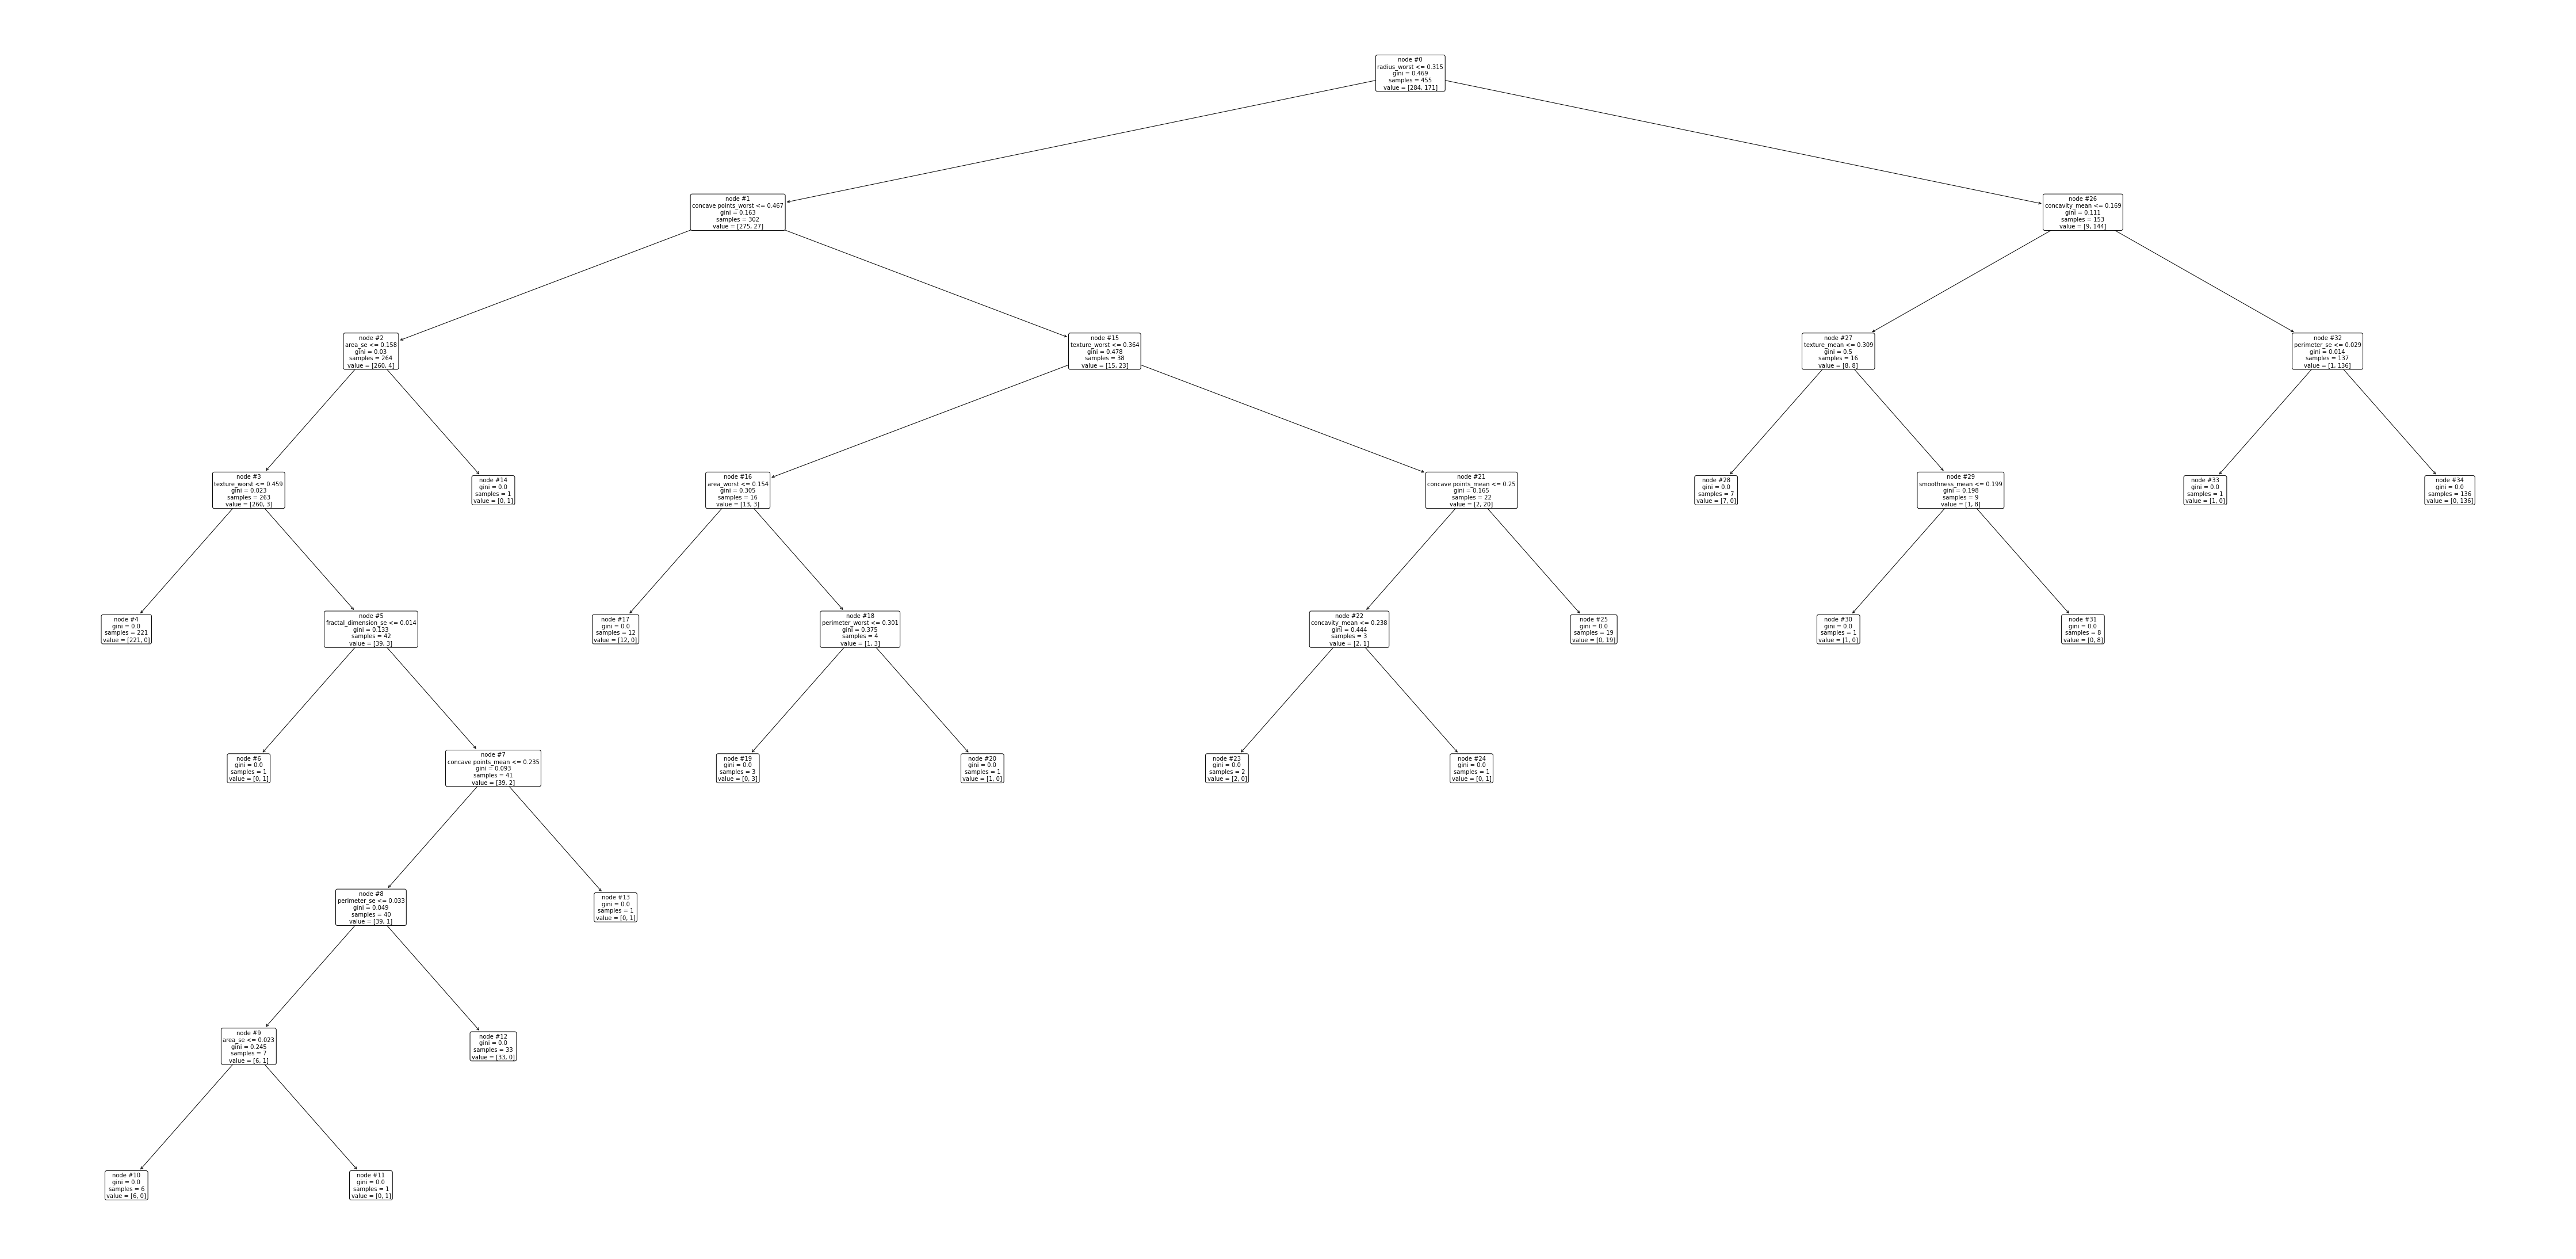

In [16]:
#### Plot the dt tree.
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(80,40))
tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True

In [17]:
#### retrieve the input and cf vectors.
gs_input = input_and_cf['input'].loc[99]
gs_cf = input_and_cf['cf'].loc[99]


In [18]:
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph



In [19]:
#decisions, pred, leaf_id = rules.get_decision_process(np.array(gs_input).reshape(1, -1), models['dt'], df_info.feature_names)
#print(leaf_id)

In [20]:
feature_names=df_info.feature_names
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

In [21]:
#decisions, pred, leaf_id = rules.get_decision_process(np.array(gs_cf).reshape(1, -1), models['dt'], df_info.feature_names)
#print(leaf_id)

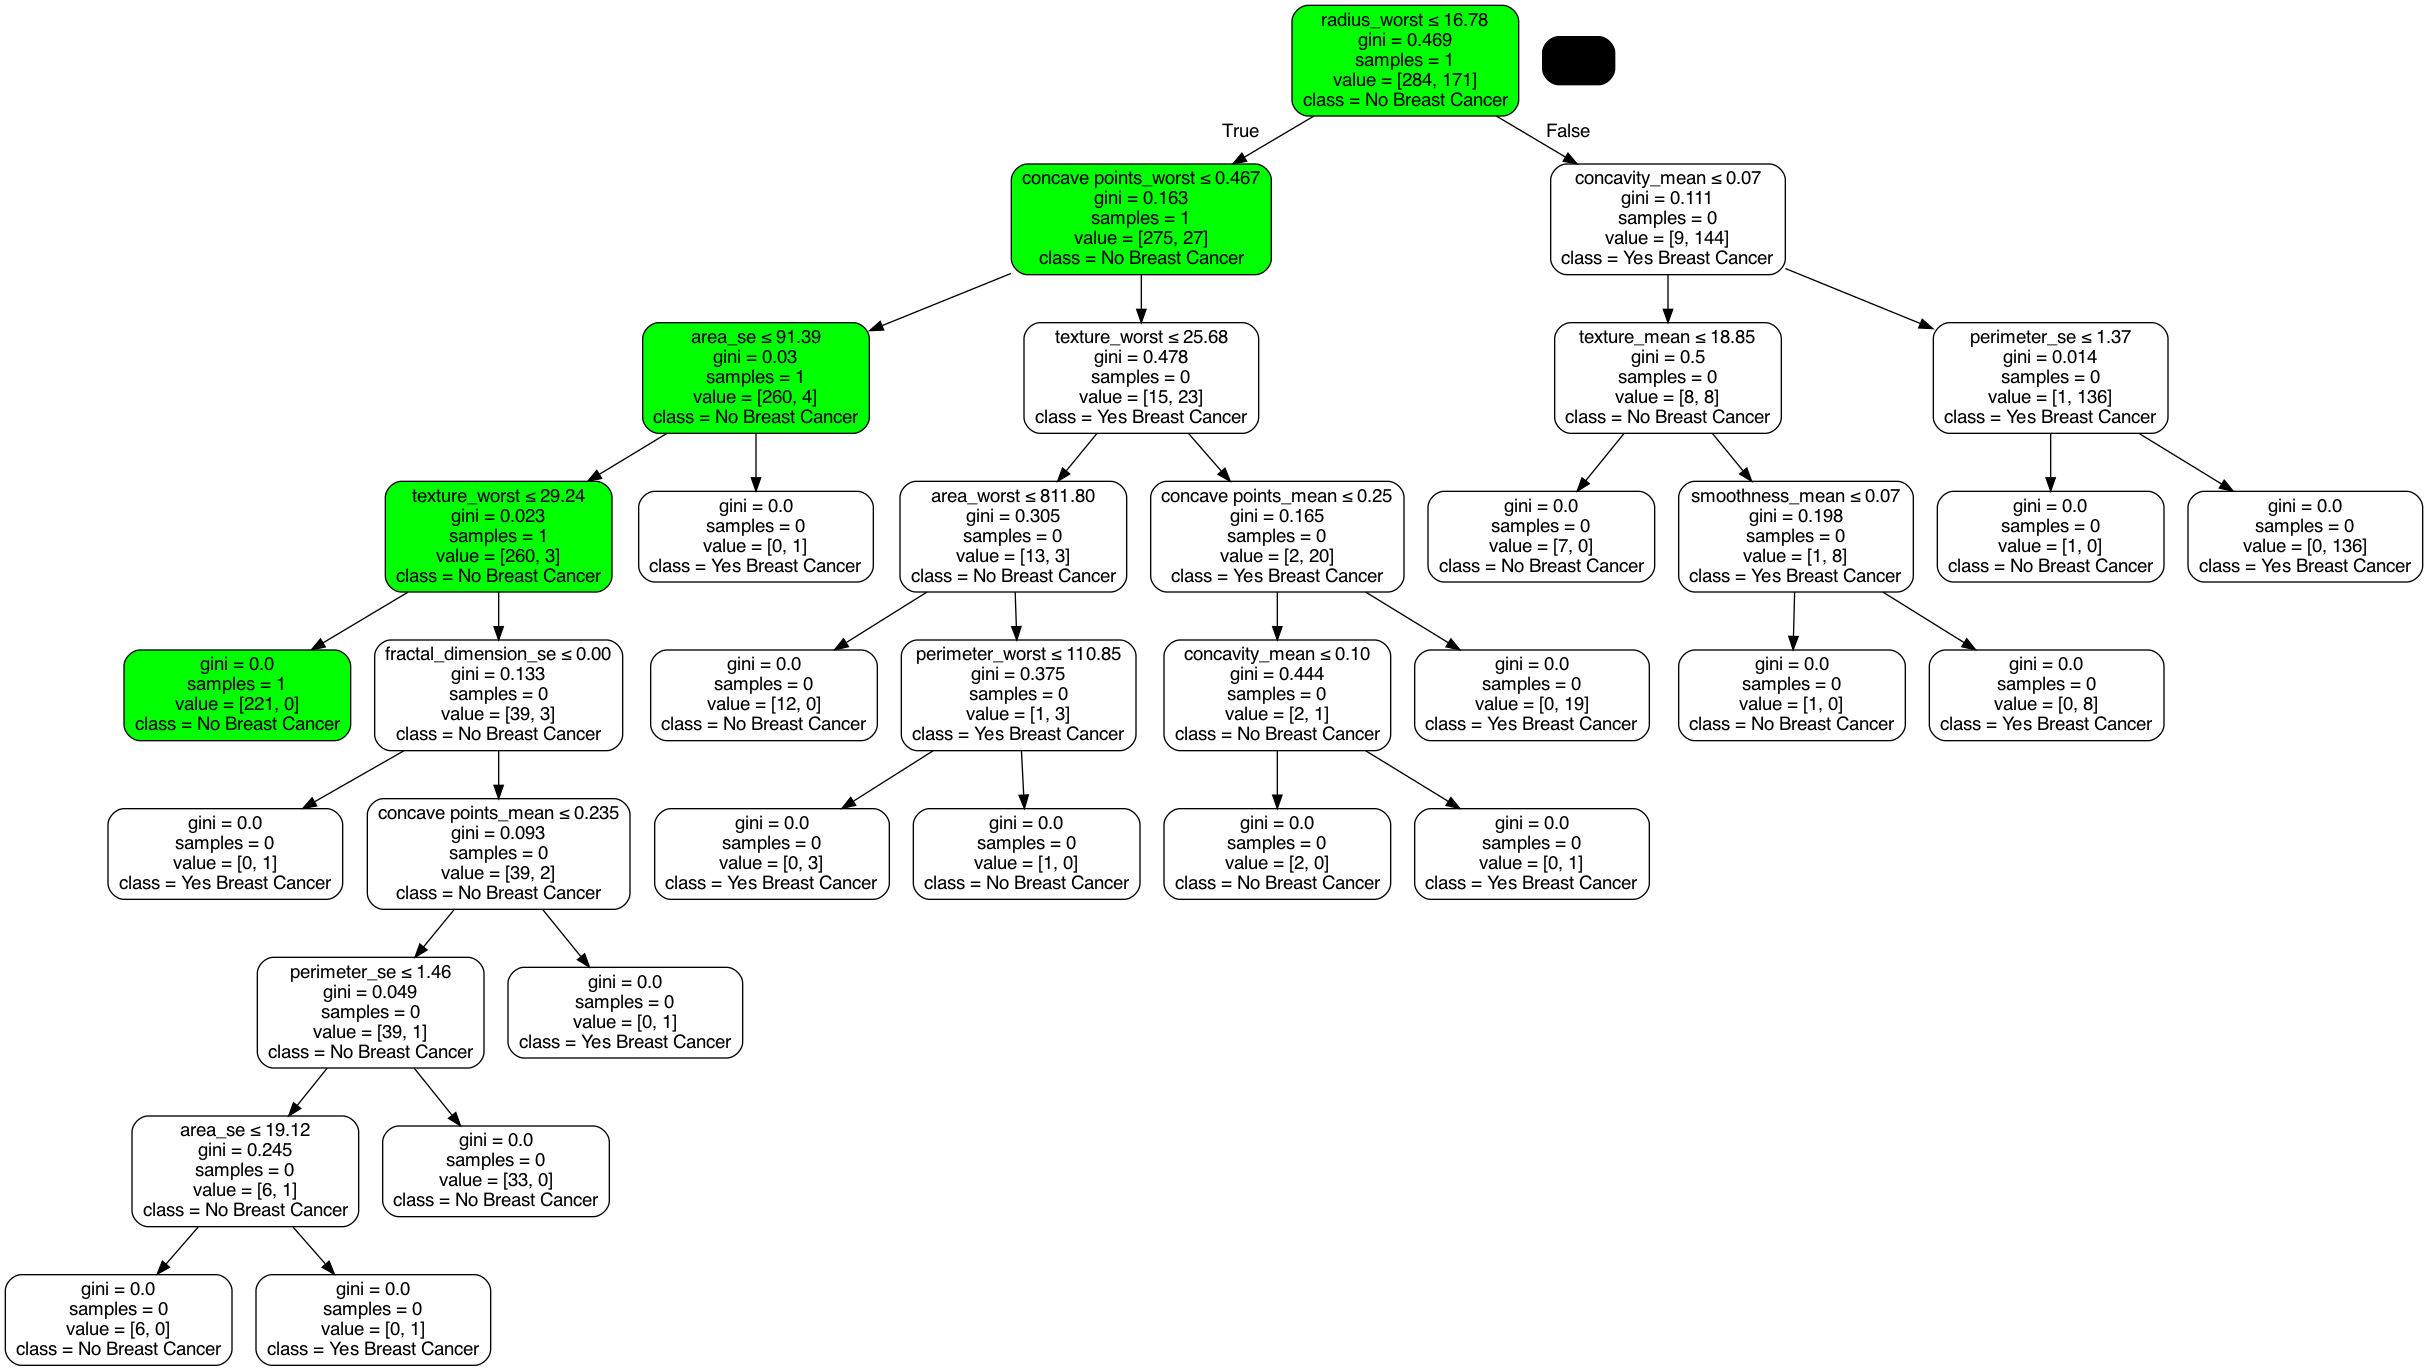

In [22]:
INDX = 99
exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), gs_input, INDX, 'true_positives', filepath)
img


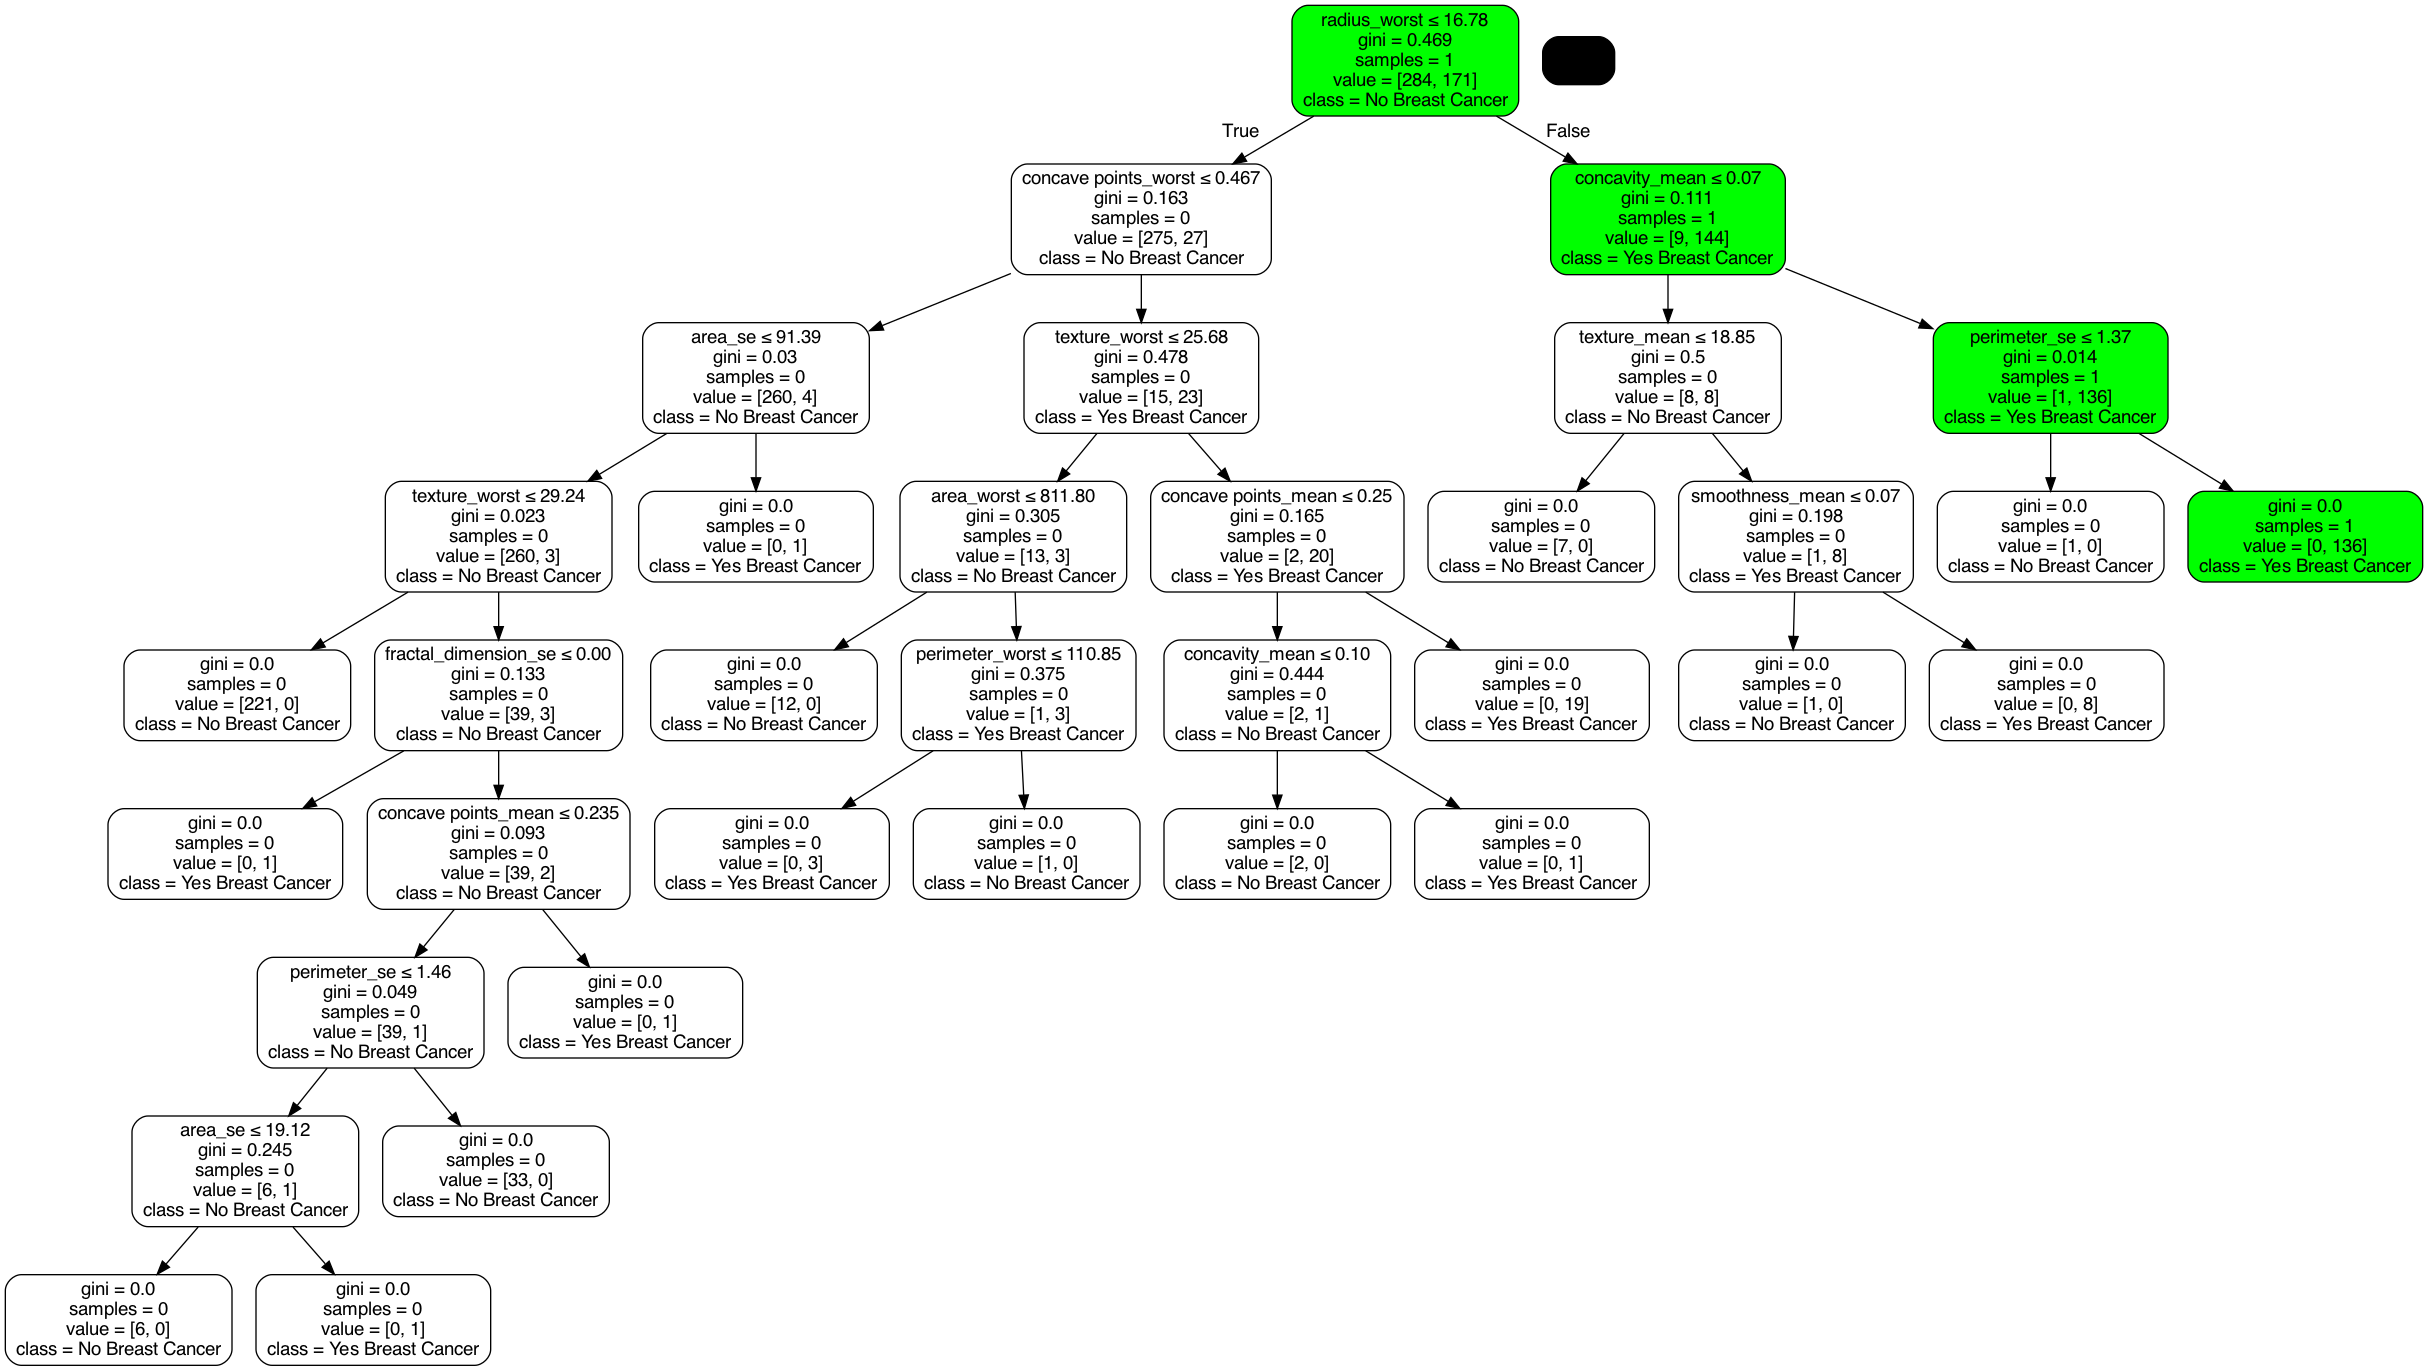

In [23]:
#exp_type = "L2_max"
INDX = 99
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), gs_cf, INDX, 'true_positives', filepath)
img

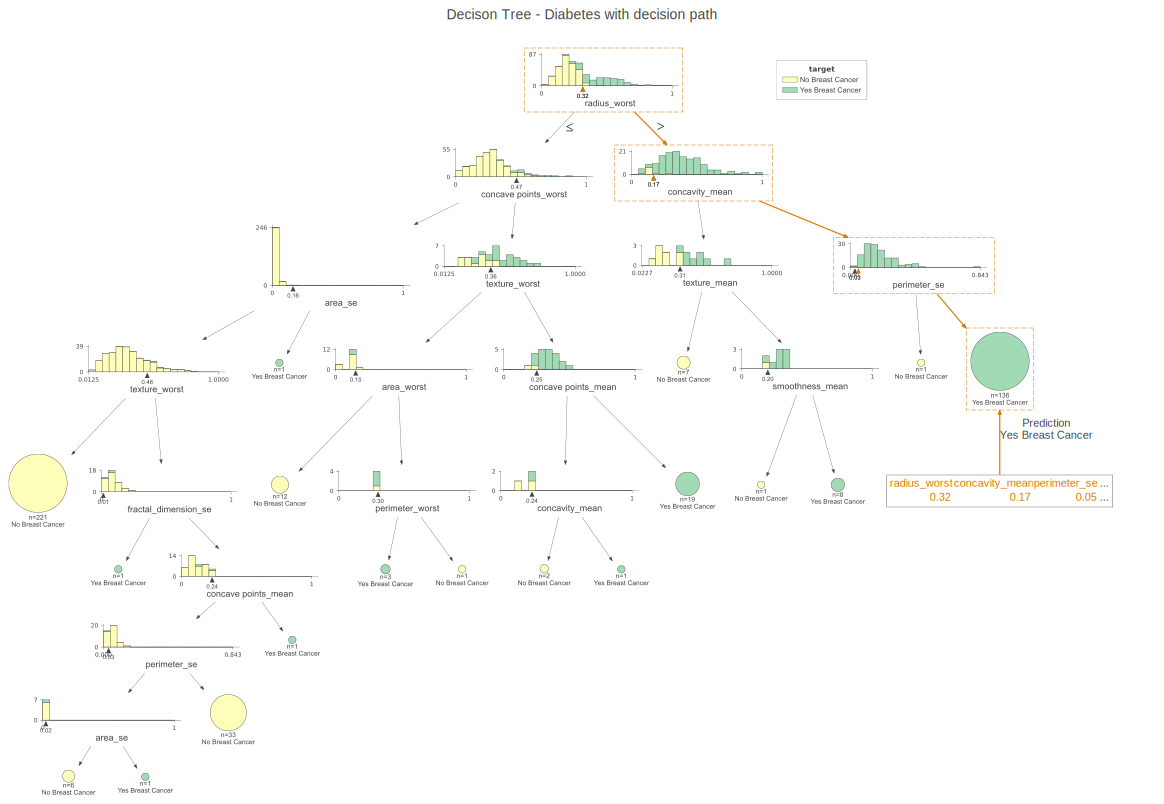

In [24]:
viz = dtreeviz(clf, 
               x_data=X_train,
               y_data=y_train,
               target_name='target',
               feature_names=df_info.feature_names, 
               class_names=class_names,
               title="Decison Tree - Diabetes with decision path",
               #orientation="LR", 
               X=gs_cf
               )

viz